In [1]:
!pip install opencv-python
!pip install tensorflow
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [2]:
from tensorflow.keras.applications import ResNet50,Xception,vgg16

In [3]:
from tensorflow.keras.layers import Dropout,BatchNormalization,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [4]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    norm_images = []
    for images in tqdm(norm_files):
        image = cv2.imread(norm_path + '/' + images)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        norm_images.append(clahe_img_new)
    norm_images = np.array(norm_images)
    return norm_images, norm_labels

In [5]:
def load_covid(cov_path):
    cov_files = np.array(os.listdir(cov_path))
    cov_labels = np.array(['covid']*len(cov_files))
    cov_images = []
    for image in tqdm(cov_files):
        image = cv2.imread(cov_path +  '/' + image)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        cov_images.append(clahe_img_new)
    cov_images = np.array(cov_images)
    return cov_images, cov_labels

In [6]:
def load_noncov(noncov_path):
    noncov_files = np.array(os.listdir(noncov_path))
    noncov_labels = np.array([noncov_file.split()[0].lower() for noncov_file in noncov_files])
    noncov_images = []
    for image in tqdm(noncov_files):
        image = cv2.imread(noncov_path +  '/' + image)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        noncov_images.append(clahe_img_new)
    noncov_images = np.array(noncov_images)
    return noncov_images, noncov_labels

In [7]:
norm_images,norm_label=load_normal('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/Normal/images_train')

100%|██████████| 7137/7137 [02:20<00:00, 50.88it/s]


In [8]:
cov_images,cov_lables = load_covid('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/COVID/images_train')

100%|██████████| 2538/2538 [00:20<00:00, 125.36it/s]


In [9]:
noncov_images,noncov_labels = load_noncov('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/NONCOVID/images_train')

100%|██████████| 4212/4212 [00:33<00:00, 125.80it/s]


In [10]:
X_train = np.append(norm_images,cov_images,axis=0)

In [11]:
X_train = np.append(X_train,noncov_images,axis=0)

In [12]:
y_train = np.append(norm_label,cov_lables)

In [13]:
y_train = np.append(y_train,noncov_labels)

In [14]:
print(y_train.shape)
X_train.shape

(13887,)


(13887, 100, 100, 3)

In [15]:
print(np.unique(y_train, return_counts=True))

(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([2538, 4212, 7137], dtype=int64))


Displaying images


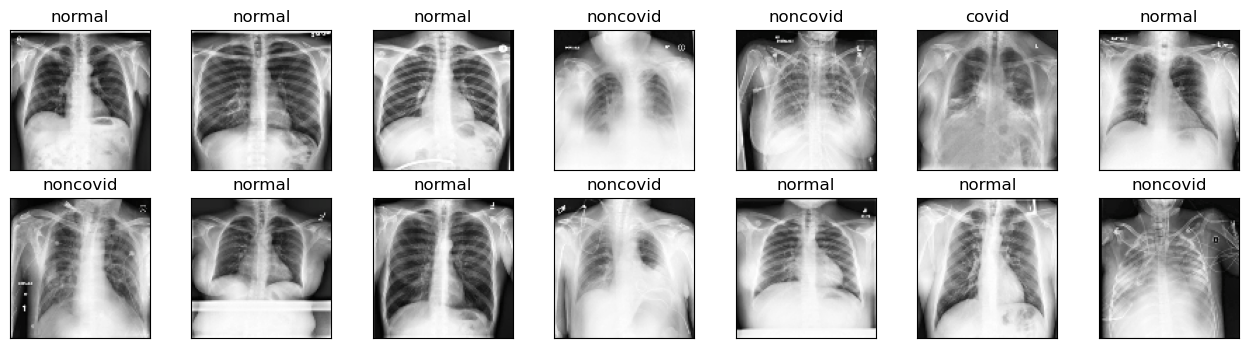

In [16]:
print('Displaying images')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))
indices = np.random.choice(len(X_train), 14)
counter = 0
for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [17]:
covid_test,testcov_labels = load_covid('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/COVID/images_test')

100%|██████████| 882/882 [00:07<00:00, 121.27it/s]


In [18]:
norm_test,testnorm_labels = load_normal('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/Normal/images_test')

100%|██████████| 2511/2511 [00:20<00:00, 124.53it/s]


In [19]:
noncov_test,testnoncov_labels = load_noncov('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/NONCOVID/images_test')

100%|██████████| 1494/1494 [00:11<00:00, 129.35it/s]


In [20]:
X_test = np.append(norm_test,covid_test,axis=0)

In [21]:
X_test = np.append(X_test,noncov_test,axis=0)

In [23]:
y_test = np.append(testnorm_labels,testcov_labels)

In [24]:
y_test = np.append(y_test,testnoncov_labels)

In [25]:
y_test.shape
X_test.shape

(4887, 100, 100, 3)

In [26]:
noncov_Val,Valnoncov_labels = load_noncov('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/NONCOVID/images_val')

100%|██████████| 306/306 [00:02<00:00, 123.66it/s]


In [27]:
norm_Val,Val_labels = load_normal('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/Normal/images_val')

100%|██████████| 544/544 [00:04<00:00, 123.35it/s]


In [28]:
covid_Val,Valcov_labels = load_covid('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/COVID/images_val')

100%|██████████| 196/196 [00:01<00:00, 135.30it/s]


In [29]:
X_val = np.append(norm_Val,covid_Val,axis=0)

In [30]:
X_val = np.append(X_val,noncov_Val,axis=0)

In [32]:
y_val = np.append(Val_labels,Valcov_labels)

In [33]:
y_val = np.append(y_val,Valnoncov_labels)

In [34]:
y_train_new = y_train[:, np.newaxis]
y_test_new = y_test[:, np.newaxis]
y_val_new = y_val[:,np.newaxis]

In [36]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],3)
X_val.shape

(1046, 100, 100, 3)

In [37]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train_new)
y_test_one_hot = one_hot_encoder.transform(y_test_new)
y_val_one_hot = one_hot_encoder.transform(y_val_new)
y_val_one_hot.shape

(1046, 3)

In [38]:
uniqs = np.unique(y_train)
uniq = uniqs.reshape(-1,1)

print(uniq)

newarr = one_hot_encoder.fit_transform(uniq)
newarr

[['covid']
 ['noncovid']
 ['normal']]


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [39]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([2538, 4212, 7137], dtype=int64))
(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([ 882, 1494, 2511], dtype=int64))
(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([196, 306, 544], dtype=int64))


In [40]:
print(X_train.shape)
print(y_train_one_hot.shape)

(13887, 100, 100, 3)
(13887, 3)


In [41]:
print(X_test.shape,y_test_one_hot.shape)

(4887, 100, 100, 3) (4887, 3)


In [42]:
print(X_val.shape,y_val_one_hot.shape)

(1046, 100, 100, 3) (1046, 3)


In [43]:
Batch_size = 64
Epochs = 100
size = 100
N_ch = 3

In [44]:
resnet50 = ResNet50(weights = "imagenet",include_top = False)

In [45]:
def build_resnet50():
    resnet50 = ResNet50(weights = "imagenet",include_top = False)
    input = Input(shape=(size,size,N_ch))
    x = Conv2D(3,(3,3),padding = "same")(input)
    x = resnet50(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.5)(x)
    
    output = Dense(3,activation="softmax",name="root")(x)
    model = Model(input,output)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [46]:
model_resnet50 = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet50_Model_CLAHE.keras', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,
                             horizontal_flip=True,vertical_flip=True) 

datagen.fit(X_train)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,303 (92.02 MB)

 Trainable params: 24,064,087 (91.80 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [47]:
early_stop = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

In [49]:
history_resnet = model_resnet50.fit(datagen.flow(X_train, y_train_one_hot, batch_size=Batch_size),steps_per_epoch=X_train.shape[0] // Batch_size,
               epochs=Epochs,
               verbose=1,
               callbacks=[annealer, checkpoint,early_stop],
               validation_data=(X_val, y_val_one_hot))

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5902 - loss: 1.2728
Epoch 1: val_loss improved from inf to 2.42647, saving model to ResNet50_Model_CLAHE.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.5902 - loss: 1.2736 - val_accuracy: 0.2161 - val_loss: 2.4265 - learning_rate: 0.0010
Epoch 2/100
  1/216 ━━━━━━━━━━━━━━━━━━━━ 4:07 1s/step - accuracy: 0.6875 - loss: 1.1917

C:\Users\imdin\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 2.42647 to 2.37301, saving model to ResNet50_Model_CLAHE.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6875 - loss: 1.1917 - val_accuracy: 0.2046 - val_loss: 2.3730 - learning_rate: 0.0010
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6138 - loss: 1.3138
Epoch 3: val_loss improved from 2.37301 to 0.91423, saving model to ResNet50_Model_CLAHE.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.6140 - loss: 1.3127 - val_accuracy: 0.6568 - val_loss: 0.9142 - learning_rate: 0.0010
Epoch 4/100
  1/216 ━━━━━━━━━━━━━━━━━━━━ 4:06 1s/step - accuracy: 0.6875 - loss: 0.8501
Epoch 4: val_loss improved from 0.91423 to 0.88341, saving model to ResNet50_Model_CLAHE.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6875 - loss: 0.8501 - val_accuracy: 0.6568 - val_loss: 0.8834 - learning_rate: 0.0010
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6688 - loss: 0.8280
Epoch 5: val_loss did not im

KeyboardInterrupt: 

In [ ]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

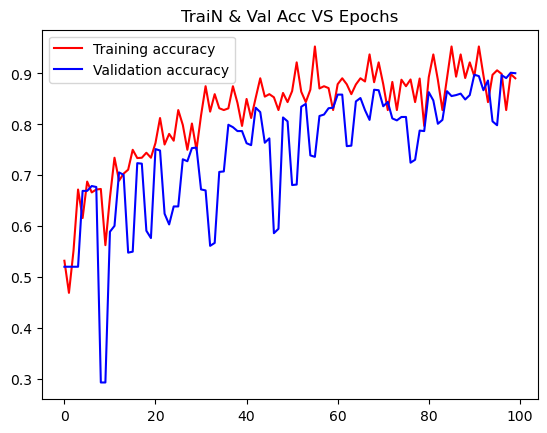

<Figure size 640x480 with 0 Axes>

In [470]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

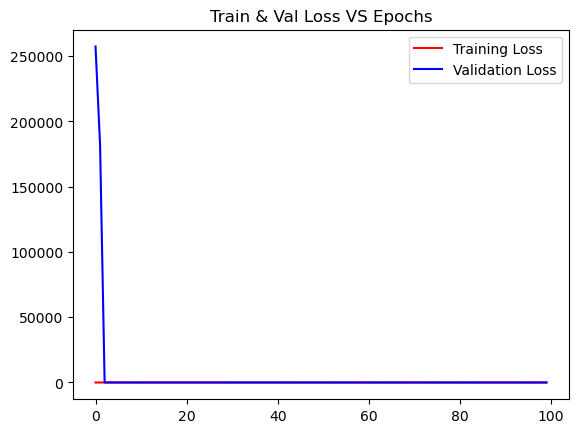

<Figure size 640x480 with 0 Axes>

In [471]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()